In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, recall_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.svm import SVC, LinearSVC #O(m**2.3 x n), O(mxn )
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier, BaggingClassifier #rfcl Feature Imp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preprocessing

In [60]:
df=pd.read_csv('income_evaluation.csv')
y_train=df[' income']
y_train=y_train==' >50K' #Make the output a boolean
X_train=df.drop([' income'], axis=1)

In [61]:
X_train.loc[0:3,:]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States


In [62]:
X_train.info(verbose=True, null_counts=True) #No null values, so no need to handle missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlwgt          32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB
<ipython-input-62-c5d70de64e2c>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  X_train.info(verbo

In [63]:
#Use this for faster processing. We will be analyzing the columns however, so we will transform back to a dataframe.
def ohe_to_array(df):
    col_transformer_min_max=ColumnTransformer([('one_hot', OneHotEncoder(), list_objs),
                                            ('min_max', MinMaxScaler(), list_nums)])
    sparse_arr=col_transformer_min_max.fit_transform(df)
    train_data=sparse_arr.toarray()
    return train_data

In [64]:
#Now we one-hot encode our data

def ohe_to_df(df):
    global list_objs, list_nums
    list_nums=[column for column in df.columns if df[column].dtype==np.dtype('int')]
    list_objs=[column for column in df.columns if df[column].dtype==np.dtype('O')]
    ohe=OneHotEncoder()
    arr1_sparse=ohe.fit_transform(df[list_objs])
    arr1=arr1_sparse.toarray()
    df1=pd.DataFrame(arr1, columns=ohe.get_feature_names())
    df=pd.merge(df1,df[list_nums], left_index=True, right_index=True)
    return df

def rename_columns(df):
    for i in df.columns:
        if len(i.split('_'))>1:
            try:
                index=int(i.split('_')[0][-1])
                df.rename(columns= { i : '{}_'.format(list_objs[index]) + i.split('_')[-1]} ,inplace=True)
            except Exception as x:
                print(x)

X_train=ohe_to_df(X_train)
rename_columns(X_train)
X_train.loc[0:3]

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,...,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,39,77516,13,2174,0,40
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,50,83311,13,0,0,13
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,38,215646,9,0,0,40
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,53,234721,7,0,0,40


In [65]:
#We will use k-fold cross validation, but will leave a small hold-out test set nonetheless
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=.05, random_state=41)

## Dimensionality reduction and Data analysis

In [68]:
corr_arr=X_train.corrwith(y_train)
dict_index={}
list_keywords=[' workclass_',' education_',' marital-status_', ' occupation_',' relationship_',' race_',' sex_', ' native-country_', 'age',' fnlwgt', ' education-num', ' capital-gain', ' capital-loss',
       ' hours-per-week']
for i in list_keywords:
    dict_index[i]=[(ind, round(corr_arr[ind],2)) for ind in corr_arr.index if i in ind]

In [69]:
#Interestingly enough, whether or not someone is self employed in a corporate entity setting, is the best predictor of whether or not you will be payed more than $50K:
dict_index[' workclass_']

[(' workclass_ ?', -0.08),
 (' workclass_ Federal-gov', 0.06),
 (' workclass_ Local-gov', 0.03),
 (' workclass_ Never-worked', -0.01),
 (' workclass_ Private', -0.08),
 (' workclass_ Self-emp-inc', 0.14),
 (' workclass_ Self-emp-not-inc', 0.03),
 (' workclass_ State-gov', 0.02),
 (' workclass_ Without-pay', -0.01)]

In [70]:
#It's clear that getting a Masters, Bachelors, or Doctorate, is of utmost importance if you want to make a decent wage above $50K
dict_index[' education_']

[(' education_ 10th', -0.07),
 (' education_ 11th', -0.09),
 (' education_ 12th', -0.04),
 (' education_ 1st-4th', -0.03),
 (' education_ 5th-6th', -0.05),
 (' education_ 7th-8th', -0.06),
 (' education_ 9th', -0.06),
 (' education_ Assoc-acdm', 0.01),
 (' education_ Assoc-voc', 0.01),
 (' education_ Bachelors', 0.18),
 (' education_ Doctorate', 0.13),
 (' education_ HS-grad', -0.13),
 (' education_ Masters', 0.18),
 (' education_ Preschool', -0.02),
 (' education_ Prof-school', 0.16),
 (' education_ Some-college', -0.06)]

In [71]:
#Perhaps it's good to marry, or perhaps the younger folk who make less money simply are creating a bias in our data. What is surprising, however, is that income is correlated to whether or not your spouse is in the armed forces, a civilian, or if you divorced.
dict_index[' marital-status_']

[(' marital-status_ Divorced', -0.13),
 (' marital-status_ Married-AF-spouse', 0.01),
 (' marital-status_ Married-civ-spouse', 0.45),
 (' marital-status_ Married-spouse-absent', -0.04),
 (' marital-status_ Never-married', -0.32),
 (' marital-status_ Separated', -0.07),
 (' marital-status_ Widowed', -0.06)]

I'm not going to show the output for the rest, for the sake of keeping the notebook neat, but it's easy to see/verify that:
Being in an executive/managerial position or having a specialty job, being a male in a relationship, being white (has a slight correlation), being from the United States (especially not being from Mexico),
level of education, capital gain/loss, age, and hours worked per week is the most correlated with having a >50K salary. Surprisingly, whether or not you were a male, and whether or not you were currently married to a civilian, had the greatest correlation to the higher salary.

In [72]:
columns_keep=list(corr_arr[abs(corr_arr)>0.1].index) #If they have an absolute value of greater than .1:
X_train=X_train[columns_keep]
X_test=X_test[columns_keep]

We have reduced the number of features by 84 (108 to 24)! As we will see, the performance is nearly identical despite having nearly 1/5th of the dimensions

## Classification:
LogisticRegression:

In [155]:
def plt_roc(fpr, tpr, label):
    plt.plot(fpr, tpr, label=label)
    plt.legend()
    plt.title('train set')
    plt.show()
def show_scores(model,X_train,y_train,X_test,y_test):
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print('Accuracy on train set = ',accuracy_score(y_train, y_pred_train))
    print('Recall on train set = ',recall_score(y_train, y_pred_train))
    print('Precision on train set = ',precision_score(y_train, y_pred_train), '\n')
    print('Accuracy on test set = ',accuracy_score(y_test, y_pred_test))
    print('Recall on test set = ',recall_score(y_test, y_pred_test))
    print('Precision on test set = ',precision_score(y_test, y_pred_test,'\n'))

    y_scores=model.decision_function(X_train)
    fpr,tpr, thresholds=roc_curve(y_train_pred, y_scores)
    label=list(grid_search_logreg.best_estimator_.named_steps.keys())[-1]
    plt_roc(fpr, tpr, label)
    print('Area under curve for train set:',round(roc_auc_score(y_train, y_scores),3), 'out of 1')

In [94]:
pipe_svc=Pipeline([('scaler',MinMaxScaler()), ('logistic_reg', LogisticRegression(max_iter=1000))])
parameters=[{'scaler':[StandardScaler()], 'logistic_reg__penalty':['l2'], 'logistic_reg__C':[1,0.1,1e-2,1e-3] ,'logistic_reg__tol':[1e-5, 1e-4,1e-3]},
            {'scaler':[MinMaxScaler()], 'logistic_reg__penalty':['l2'], 'logistic_reg__C':[1,0.1,1e-2,1e-3] ,'logistic_reg__tol':[1e-5, 1e-4, 1e-3]}]
grid_search_logreg = GridSearchCV( pipe_svc, parameters, n_jobs=-1)
grid_search_logreg.fit(X_train,y_train)
grid_search_logreg.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_reg',
                 LogisticRegression(C=0.1, max_iter=1000, tol=1e-05))])

0.8473101746301065

Accuracy on train set =  0.847051597051597
Recall on train set =  0.5765874614042154
Precision on train set =  0.7314373297002725 

Accuracy on test set =  0.8367096378146102
Recall on test set =  0.5561224489795918
Precision on test set =  0.7032258064516129


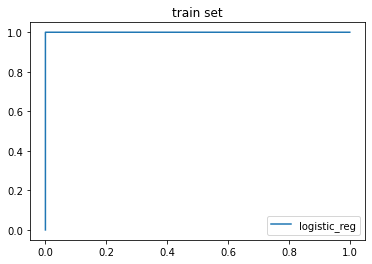

Area under curve for train set: 0.903 out of 1


In [156]:
#As you can tell, it seems that the model is struggling with identifying True positives in such a way that implies that our threshold may be too low.
show_scores(grid_search_logreg, X_train, y_train, X_test, y_test)

.852 acc. score without Dim reduction, and .847 despite nearly 1/5th of the number of features!

### SVCs:

In [91]:
pipe_SVC=Pipeline([('scaler',StandardScaler()),('svc',LinearSVC())])
parameters=

30932